# Lecture 6 - Student Notebook

ASSISTments is a free tool for assigning and assessing math problems and homework. Teachers can select and assign problem sets. Once they get an assignment, students can complete it at their own pace and with the help of hints, multiple chances, and immediate feedback. Teachers get instant results broken down by individual student or for the whole class. The dataset involves 4,217 middle-school students practicing an electronic tutor that teaches and evaluates students in grade-school math, with a total of 525,534 trials. The student data are in a comma-delimited text file with one row per trial. The columns should correspond to a trial's user id, the order id (timestamp), the skill name, and and whether the student produced a correct response in the trial. More information on the platform can be found [here](https://www.commonsense.org/education/website/assistments). 

The ASSISTments data sets are often used for benchmarking knowledge tracing models. We will play with a simplified data set that contains the following columns:

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| user_id | The ID of the student who is solving the problem.  | |
| order_id | The temporal ID (timestamp) associated with the student's answer to the problem.  | |
| skill_name | The name of the skill associated with the problem. | |
| correct | The student's performance on the problem: 1 if the problem's answer is correct at the first attempt, 0 otherwise. 

We first load the data set.

In [1]:
# Principal package imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

# Scikit-learn package imports
from sklearn import feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, roc_auc_score

# PyBKT package imports
from pyBKT.models import Model

DATA_DIR = "./course_data/"

In [2]:
assistments = pd.read_csv(DATA_DIR + 'assistments.csv', low_memory=False).dropna()
assistments.head()

,user_id,order_id,skill_name,correct
0,64525,33022537,Box and Whisker,1
1,64525,33022709,Box and Whisker,1
2,70363,35450204,Box and Whisker,0
3,70363,35450295,Box and Whisker,1
4,70363,35450311,Box and Whisker,0


Next, we print the number of unique students and skills in this data set.

In [3]:
print("Number of unique students in the dataset:", len(set(assistments['user_id'])))
print("Number of unique skills in the dataset:", len(set(assistments['skill_name'])))

Number of unique students in the dataset: 4151
Number of unique skills in the dataset: 110


To keep things simpler for demonstration purposes, we will focus on the following 6 skills in this lecture:  
`'Circle Graph', 'Venn Diagram', 'Mode', 'Division Fractions', 'Finding Percents', 'Area Rectangle'`

In [4]:
skills_subset = ['Circle Graph', 'Venn Diagram', 'Mode', 'Division Fractions', 'Finding Percents', 'Area Rectangle']
data = assistments[assistments['skill_name'].isin(skills_subset)]

print("Skill set:", set(data['skill_name']))
print("Number of unique students in the subset:", len(set(data['user_id'])))
print("Number of unique skills in the subset:", len(set(data['skill_name'])))

Skill set: {'Division Fractions', 'Circle Graph', 'Finding Percents', 'Area Rectangle', 'Venn Diagram', 'Mode'}
Number of unique students in the subset: 1527
Number of unique skills in the subset: 6


To keep things simpler for demonstration purposes, we will focus on the following 6 skills in this lecture:  
`'Circle Graph', 'Venn Diagram', 'Mode', 'Division Fractions', 'Finding Percents', 'Area Rectangle'`

In [5]:
skills_subset = ['Circle Graph', 'Venn Diagram', 'Mode', 'Division Fractions', 'Finding Percents', 'Area Rectangle']
data = assistments[assistments['skill_name'].isin(skills_subset)]

print("Skill set:", set(data['skill_name']))
print("Number of unique students in the subset:", len(set(data['user_id'])))
print("Number of unique skills in the subset:", len(set(data['skill_name'])))

Skill set: {'Division Fractions', 'Circle Graph', 'Finding Percents', 'Area Rectangle', 'Venn Diagram', 'Mode'}
Number of unique students in the subset: 1527
Number of unique skills in the subset: 6


## BKT Models - Training & Prediction

We will use a train-test setting (20% of students in the test set). The `create_iterator` function creates an iterator object able to split student's interactions included in data in 10 folds such that the same student does not appear in two different folds. To do so, we appropriately initialize a scikit-learn's GroupShuffleSplit iterator with 80% training set size and non-overlapping groups, then return the iterator.

In [6]:
def create_iterator(data):
    '''
    Create an iterator to split interactions in data into train and test, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''    
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index)) 
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupShuffleSplit(n_splits=1, train_size=.8, test_size=0.2, random_state=0).split(X, groups=groups)

Next, we train a BKT model for each skill on the training data set and then predict on the test data set.
We obtain `df_preds`, a data frame containing the predictions for each user and skill in the test data set. We output the overall RMSE and AUC scores.

In [7]:
rmse_bkt, auc_bkt = [], []
df_preds = pd.DataFrame()
# Train a BKT model for each skill
for skill in skills_subset:
    print("--", skill, "--")
    skill_data = data[data['skill_name'] == skill]
    for iteration, (train_index, test_index) in enumerate(create_iterator(skill_data)):
        # Split data in training and test sets
        X_train, X_test = skill_data.iloc[train_index], skill_data.iloc[test_index]
        # Initialize and fit the model
        model = Model(seed=0)
        %time model.fit(data=X_train) 
        # Compute predictions
        preds = model.predict(data=X_test)[['user_id', 'skill_name', 'correct', 'correct_predictions']]
        df_preds = df_preds.append(preds)
        
# Print the the resulting dataframe
display(df_preds)

# Compute overall RMSE and AUC
rmse = mean_squared_error(df_preds.correct, df_preds.correct_predictions, squared = False)
AUC = roc_auc_score(df_preds.correct, df_preds.correct_predictions)
print('RMSE:', rmse, 'AUC:', AUC)

-- Circle Graph --
CPU times: user 61.7 ms, sys: 24.9 ms, total: 86.6 ms
Wall time: 23.8 ms
-- Venn Diagram --
CPU times: user 127 ms, sys: 62.5 ms, total: 189 ms
Wall time: 32.2 ms
-- Mode --
CPU times: user 30.5 ms, sys: 18.8 ms, total: 49.3 ms
Wall time: 7.65 ms
-- Division Fractions --
CPU times: user 52.1 ms, sys: 29.4 ms, total: 81.5 ms
Wall time: 12.8 ms
-- Finding Percents --
CPU times: user 88.8 ms, sys: 41.1 ms, total: 130 ms
Wall time: 21.1 ms
-- Area Rectangle --
CPU times: user 110 ms, sys: 62.5 ms, total: 173 ms
Wall time: 27.7 ms


,user_id,skill_name,correct,correct_predictions
3969,64525,Circle Graph,1,0.46694
3970,64525,Circle Graph,1,0.63949
3971,64525,Circle Graph,1,0.69695
3972,64525,Circle Graph,0,0.70977
3973,64525,Circle Graph,1,0.70408
...,...,...,...,...
337153,96264,Area Rectangle,1,0.89256
337154,96264,Area Rectangle,1,0.97978
337159,96270,Area Rectangle,1,0.89256
337167,96292,Area Rectangle,1,0.89256


RMSE: 0.3648431256268419 AUC: 0.8235642883338723


### Your Turn - Training & Prediction

Next, we assume that the RMSE and AUC might differ depending on the skill. Your task is to:
1. Compute one of the metrics (RMSE or AUC) separately for each skill. 
2. Compute the mean of the selected metric (+ standard deviation) over all skills.
3. Create a visualization that displays: the mean of the metric (+ standard deviation) over all skills *and* the metric per skill.
4. Discuss your findings.

In [ ]:
import requests

exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)

npt_config = {
    'session_name': 'lecture-06',
    'session_owner': 'mlbd-2022',
    'sender_name': input("Your name: "),
}

In [ ]:
# YOUR TURN: Your code for computing the metrics goes here

### Share your metric visualization plot with us
plt.hist(...)
send(plt, 1)
plt.show()

### Share your analysis of the metric 
metric_discussion = ""
send(metric_discussion, 2)

## BKT Models - Learning Curves

We can also analyze the BKT model as well as the skills in the data set using learning curves.

We first fit a BKT model with all default parameters, i.e., Model(seed=0) in pyBKT, on the full data data set (no split into train and test set needed as we are not assessing predictive performance of the model here, but just checking interpretation). 

In [8]:
# Initialize the model
model = Model(seed=0)

# Fit the model on the entire dataset
%time model.fit(data=data)

predictions = model.predict(data=data)[['user_id', 'skill_name', 'correct', 'correct_predictions']]

# Rename the dataframe columns as per instructions
predictions.columns = ['user_id', 'skill_name', 'y_true', 'y_pred_bkt']

CPU times: user 459 ms, sys: 155 ms, total: 614 ms
Wall time: 149 ms


In [9]:
predictions.head()

,user_id,skill_name,y_true,y_pred_bkt
3957,14,Circle Graph,0,0.45988
3958,14,Circle Graph,1,0.33391
3959,14,Circle Graph,0,0.56203
3960,14,Circle Graph,0,0.43367
3961,14,Circle Graph,0,0.31411


Next, we create a function that computes the learning curve (observed or predicted) for us by averaging over the success rate of all users at a given opportunity.

In [10]:
def avg_y_by_x(x, y):
    '''
    Compute average learning curve and number of students over the number of opportunities. 
    x is the number of opportunities.
    y the success rates of the users (can be predicted success rate or true success rate).
    '''
    # Transform lists into arrays
    x = np.array(x)
    y = np.array(y)

    # Sort the integer id representing the number of opportunities in increasing order
    xs = sorted(list(set(x)))

    # Supporting lists to store the:
    # - xv: integer identifier of the number of opportunities
    # - yv: average value across students at that number of opportunities
    # - lcb and ucb: lower and upper confidence bound
    # - n_obs: number of observartions present at that number of opportunities (on per-skill plots, it is the #students)
    xv, yv, lcb, ucb, n_obs = [], [], [], [], []

    # For each integer identifier of the number of opportunities 0, ...
    for v in xs:
        ys = [y[i] for i, e in enumerate(x) if e == v] # We retrieve the values for that integer identifier
        if len(ys) > 0: 
            xv.append(v) # Append the integer identifier of the number of opportunities
            yv.append(sum(ys) / len(ys)) # Append the average value across students at that number of opportunities
            n_obs.append(len(ys)) # Append the number of observartions present at that number of opportunities

            
            # Prepare data for confidence interval computation
            unique, counts = np.unique(ys, return_counts=True)
            counts = dict(zip(unique, counts))

            if 0 not in counts:
                counts[0] = 0
            if 1 not in counts:
                counts[1] = 0

            # Calculate the 95% confidence intervals
            ci = sc.stats.beta.interval(0.95, 0.5 + counts[0], 0.5 + counts[1])
            lcb.append(ci[0])
            ucb.append(ci[1])

    return xv, yv, lcb, ucb, n_obs

Then, we create a function for plotting learning curve and a bar chart with the number of students per opportunity for a given skill.

In [11]:
def plot_learning_curve(skill_name):
    '''
    Plot learning curve using BKT model for skill `skill_name`. 
    '''
    preds = predictions[predictions['skill_name'] == skill_name] # Retrieve predictions for the current skill

    xp = []
    yp = {}
    for col in preds.columns: # For y_true and and y_pred_bkt columns, initialize an empty list for curve values
        if 'y_' in col:
            yp[col] = []

    for user_id in preds['user_id'].unique(): # For each user
        user_preds = preds[preds['user_id'] == user_id] # Retrieve the predictions on the current skill for this user 
        xp += list(np.arange(len(user_preds))) # The x-axis values go from 0 to |n_opportunities|-1
        for col in preds.columns: 
            if 'y_' in col: # For y_true and and y_pred_bkt columns
                yp[col] += user_preds[col].tolist() # The y-axis value is the success rate for this user at that opportunity

    fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2]}) # Initialize the plotting figure

    lines = []
    for col in preds.columns:
        if 'y_' in col: # For y_true and and y_pred_bkt columns   
            x, y, lcb, ucb, n_obs = avg_y_by_x(xp, yp[col]) # Calculate mean and 95% confidence intervals for success rate 
            y = [1-v for v in y] # Transform success rate in error rate
            if col == 'y_true': # In case of ground-truth data, we also show the confidence intervals
                axs[0].fill_between(x, lcb, ucb, alpha=.1)
            model_line, = axs[0].plot(x, y, label=col) # Plot the curve
            lines.append(model_line) # Store the line to then set the legend    

    # Make decorations for the learning curve plot
    axs[0].set_title(skill_name)
    axs[0].legend(handles=lines)
    axs[0].set_ylabel('Error')
    axs[0].set_ylim(0, 1)
    axs[0].set_xlim(0, None)

    # Plot the number of observations per number of opportunities bars and make decorations
    axs[1].set_xlabel('#Opportunities')
    axs[1].bar([i for i in range(len(n_obs))], n_obs)
    axs[1].set_ylabel('#Observations')
    axs[1].set_ylim(0, 750)
    axs[1].set_xlim(0, None)

    # Plot the learning curve and the bar plot 
    return plt

We then plot the learning curve and number of opportunities per student for skill `Circle Graph`.

/Users/vinitra/miniforge3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


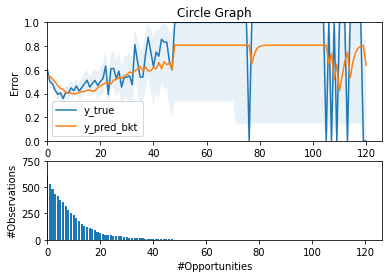

In [12]:
plt = plot_learning_curve('Circle Graph')
plt.show()

### Your Turn - Learning Curves

Visualize and interpret the learning curves and number of students per opportunity for two selected skills. You can choose from the remaining five skills: `'Venn Diagram', 'Mode', 'Division Fractions', 'Finding Percents', 'Area Rectangle'`. Send us your visualizations as well as the discussion.

In [ ]:
# YOUR TURN: Visualize the learning curve for the first skill.

skill_name = "1" # replace the skill name with one of the 5 skills above
plt = plot_learning_curve(skill_name)

### Share the plot with us
send(plt, 3)
plt.show()

In [ ]:
# YOUR TURN: What is your analysis about the learning curve for the first skill?

### Share your analysis of the learning curve with us
first_skill = ""
send(first_skill, 4)

In [ ]:
# YOUR TURN: Visualize the learning curve for the second skill.

skill_name = "2" # replace the skill name with one of the 5 skills above
plt = plot_learning_curve(skill_name)

### Share the plot with us
send(plt, 5)
plt.show()

In [ ]:
# YOUR TURN: What is your analysis about the learning curve for the second skill?

### Share your analysis of the learning curve with us
second_skill = ""
send(second_skill, 6)